## Image classification with deep learning

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import PIL.Image as Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import os

### Data exploration and preprocessing

#### Load the data

In [164]:
batch_size = 64 # how many images are processed together in each iteration during training
target_size = (48, 48)
input_shape = (48, 48, 3)

#### Load data via Keras utility & visualize them

In [165]:
img_height = 48
img_width = 48

train_ds = tf.keras.utils.image_dataset_from_directory(
    'data/veg_2_classes/train/',
    validation_split=0.2,
    subset='training',
    color_mode='grayscale',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'data/veg_2_classes/train/',
    validation_split=0.2,
    subset='validation',
    color_mode='grayscale',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [166]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [167]:
class_names

['Broccoli', 'Tomato']

##### Visualize the data via matplotlib

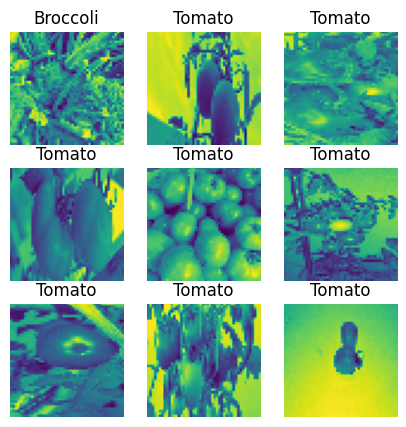

In [168]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
# extract one batch of images and labels from the train_ds dataset.
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


#### Configure and rescaling the Data

In [169]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# rescaling the RGB channel
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",input_shape=(48,48,1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.4),
        layers.RandomBrightness(0.4),
    ]
)

### Model: definition and assessment

In [170]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [171]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape = (48, 48, 1), strides=(1,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', strides=(1,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', strides=(1,1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [172]:
# compile the model
model.compile(optimizer=Adam( learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

# model.summary()


# TRAINING
epochs = 100
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/100
25/25 [==============================] - 1s 25ms/step - loss: 0.6935 - accuracy: 0.4981 - val_loss: 0.6882 - val_accuracy: 0.4950
Epoch 2/100
25/25 [==============================] - 1s 22ms/step - loss: 0.6911 - accuracy: 0.5469 - val_loss: 0.6822 - val_accuracy: 0.4950
Epoch 3/100
25/25 [==============================] - 1s 22ms/step - loss: 0.6843 - accuracy: 0.5738 - val_loss: 0.6680 - val_accuracy: 0.8025
Epoch 4/100
25/25 [==============================] - 1s 22ms/step - loss: 0.6836 - accuracy: 0.5656 - val_loss: 0.6544 - val_accuracy: 0.7800
Epoch 5/100
25/25 [==============================] - 1s 23ms/step - loss: 0.6726 - accuracy: 0.6094 - val_loss: 0.6387 - val_accuracy: 0.5825
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.6645 - accuracy: 0.6000 - val_loss: 0.6108 - val_accuracy: 0.7800
Epoch 7/100
25/25 [==============================] - 1s 23ms/step - loss: 0.6667 - accuracy: 0.5906 - val_loss: 0.6385 - val_accuracy: 0.5600
Epoch 

In [174]:
# Save the model
folder_path = 'models/'

model_name = 'dl_2cl_100ep.h5'
model.save(os.path.join(folder_path, model_name), save_format='h5')

#### Model Assessment: Training and Validation accuracy

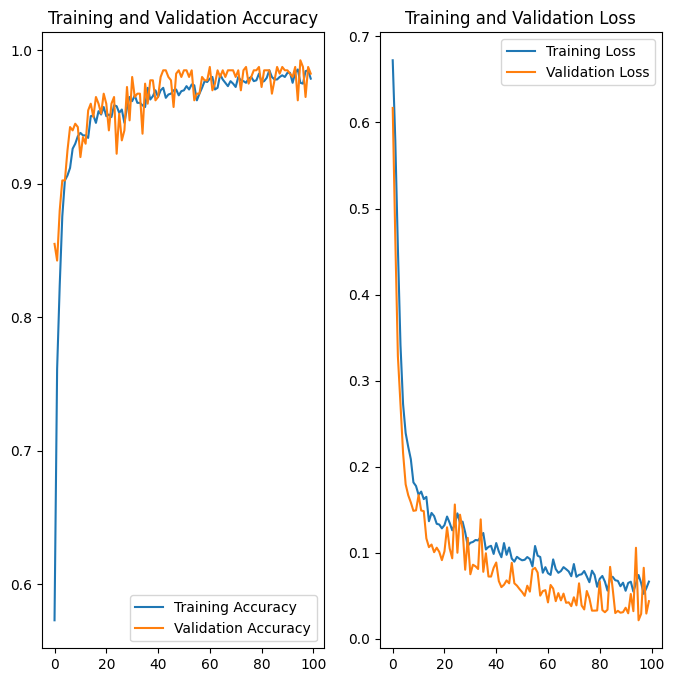

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Predict on new data

In [188]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'data/veg_2_classes/test/',
    color_mode='grayscale',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Calcola l'accuratezza sul set di immagini di test
accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy[1])


Found 400 files belonging to 2 classes.
7/7 [==============================] - 0s 5ms/step - loss: 0.7204 - accuracy: 0.7425
Test accuracy: 0.7425000071525574
